In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=42097358621b0fe297058fc0443bc2f5aff9311bee751800b2b9ede6d9863c86
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [26]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [45]:
for df in [X_train_final, X_test_final]:
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

In [27]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Logistic Regression Model


Logistic Regression Evaluation
Accuracy: 0.93
Precision: 0.93
Recall: 0.94
F1 Score: 0.93
AUC: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       544
           1       0.93      0.94      0.93       635

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



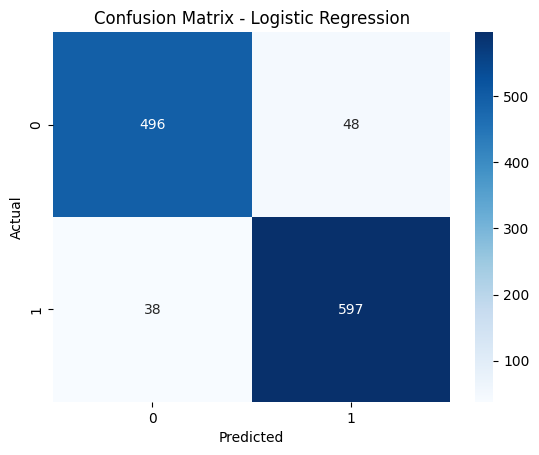

In [47]:
log_final = LogisticRegression(max_iter=1000, solver='liblinear')
log_final.fit(X_train_final, y_train)
evaluate_model("Logistic Regression", log_final, X_test_final, y_test)

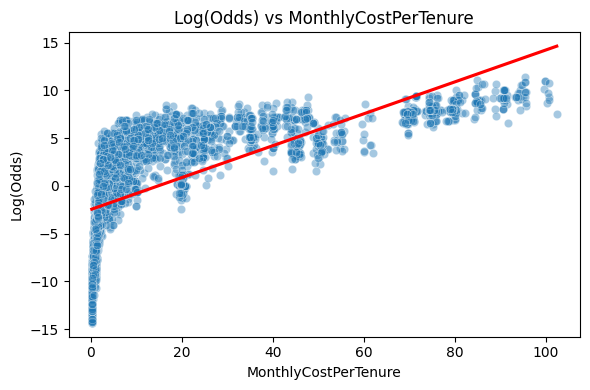

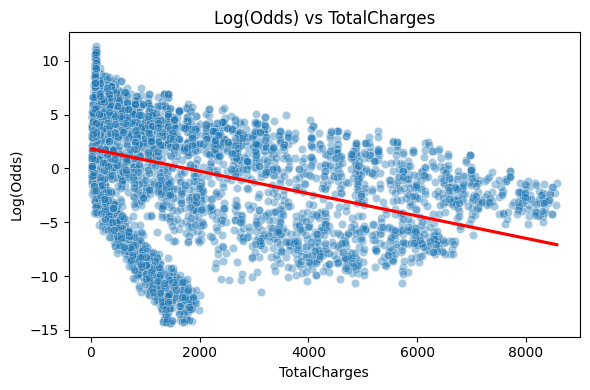

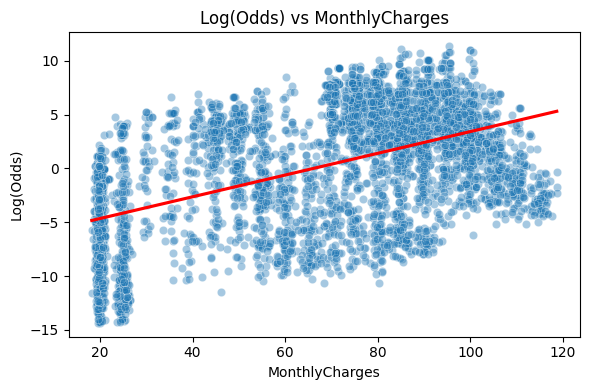

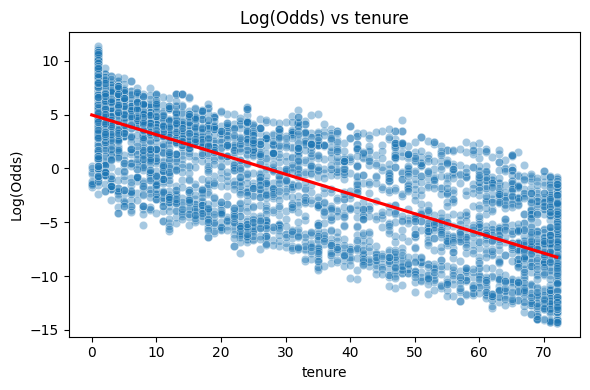

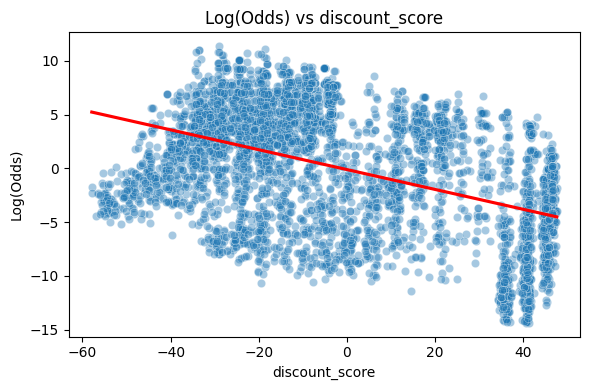

In [56]:
#Linearity Assumption: Logit vs Continuous Features
preds = log_final.predict_proba(X_train_final)[:, 1]
log_odds = np.log(preds / (1 - preds))

continuous_features = ['MonthlyCostPerTenure', 'TotalCharges', 'MonthlyCharges', 'tenure', 'discount_score']

for feature in continuous_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_train_final[feature], y=log_odds, alpha=0.4)
    sns.regplot(x=X_train_final[feature], y=log_odds, scatter=False, color='red', ci=None)
    plt.title(f'Log(Odds) vs {feature}')
    plt.ylabel('Log(Odds)')
    plt.tight_layout()
    plt.show()

In [58]:
# Outliers & Influential Points (Standardized Residuals and Cook's Distance)
y_numeric = pd.to_numeric(y_train, errors='coerce')
X_numeric = X_numeric.dropna()
y_numeric = y_numeric.loc[X_numeric.index]
X_const = sm.add_constant(X_numeric)

logit_model = sm.Logit(y_numeric, X_const).fit(disp=0)
influence = logit_model.get_influence()

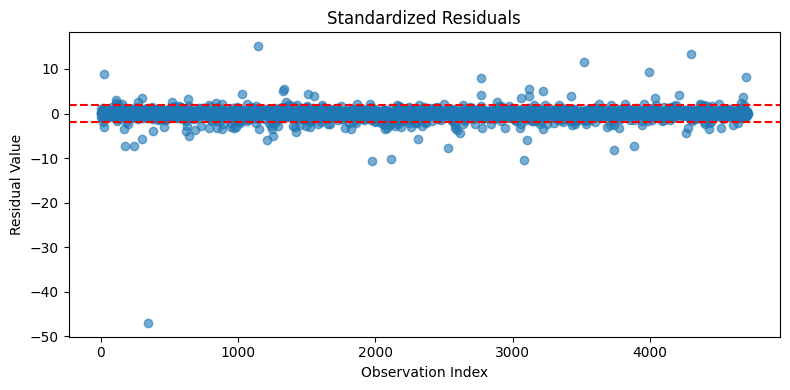

In [59]:
standardized_residuals = influence.resid_studentized
plt.figure(figsize=(8, 4))
plt.scatter(range(len(standardized_residuals)), standardized_residuals, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.title("Standardized Residuals")
plt.ylabel("Residual Value")
plt.xlabel("Observation Index")
plt.tight_layout()
plt.show()

Most points fall within the ±2 range, which is good — it suggests residuals are generally well-behaved.

There's no clear pattern or funnel shape → this supports the assumption of homoscedasticity (constant variance) and that the model is correctly specified.

Since the vast majority are concentrated near 0, the overall model seems robust.

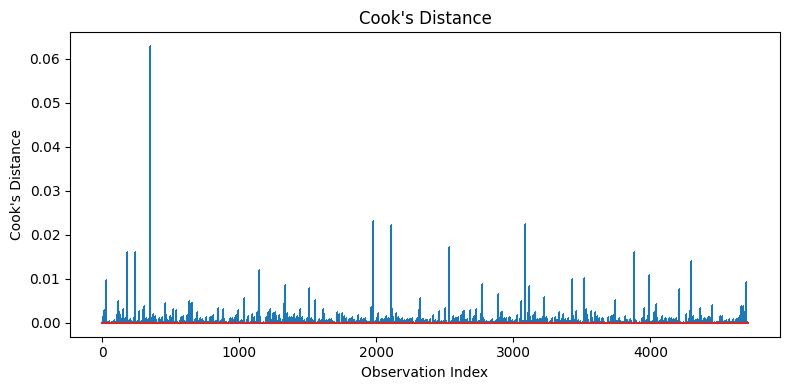

In [61]:
cooks_d = influence.cooks_distance[0]
plt.figure(figsize=(8, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.ylabel("Cook's Distance")
plt.xlabel("Observation Index")
plt.tight_layout()
plt.show()

In the plot most values are near zero, indicating low influence which is good.

However, a few spikes appear, suggesting potentially influential points. These are not necessarily outliers but may be high-leverage or high-residual cases.

In [64]:
# No Autocorrelation Assumption
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(logit_model.resid_response)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")

Durbin-Watson statistic: 2.066


Since value is very close to 2, this confirms that the residuals from logistic regression model are independent — satisfying the no autocorrelation assumption.

### SHAP for Logistic Regression


SHAP Summary for Logistic Regression


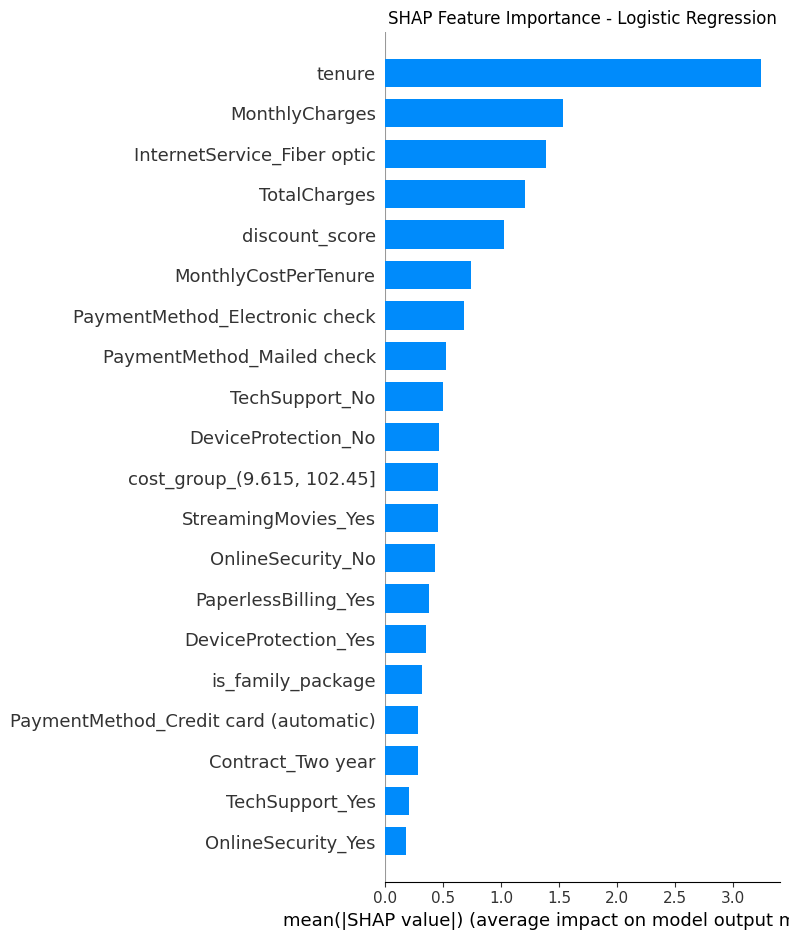

In [29]:
print("\nSHAP Summary for Logistic Regression")
explainer_log = shap.Explainer(log_final, X_train_final)
shap_values_log = explainer_log(X_test_final)
shap.summary_plot(shap_values_log, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Logistic Regression")
plt.tight_layout()
plt.show()

The SHAP feature importance plot for the Logistic Regression model reveals that customer tenure is the most influential factor in predicting churn, with longer-tenured customers being less likely to leave.

Other significant contributors include MonthlyCharges, TotalCharges, discount_score, and MonthlyCostPerTenure, indicating that customers paying higher amounts or receiving fewer discounts are more prone to churn.

Additionally, service-related features such as InternetService_Fiber optic and support options like TechSupport_No and OnlineSecurity_No also play notable roles.

In contrast, features like DeviceProtection_No and certain payment methods have comparatively lower influence on the model’s predictions. Overall, the model heavily relies on billing behavior, service type, and tenure to determine churn risk.

### LIME for Logistic Regression

In [30]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

In [31]:
print("\nLIME Explanation for Logistic Regression")
exp = explainer.explain_instance(sample_instance.values, log_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


This LIME explanation for Logistic Regression model illustrates a local interpretation for a single prediction where the model predicted churn with 97% probability. The key drivers behind this prediction include:

* Low tenure (≤ 4 months), contributing most strongly to the churn prediction (0.42 impact),

* Fiber optic internet service, which is often linked to higher churn risk,

* Low total charges and MonthlyCostPerTenure, indicating the customer is new but pays relatively more,

* Absence of Tech Support and Online Security, which are known churn indicators.

On the right side, the feature values show that the customer indeed had low tenure, used electronic check payments (often associated with higher churn), and lacked support services — all reinforcing the churn prediction.


### PDP for Logistic Regression

In [32]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - Logistic Regression


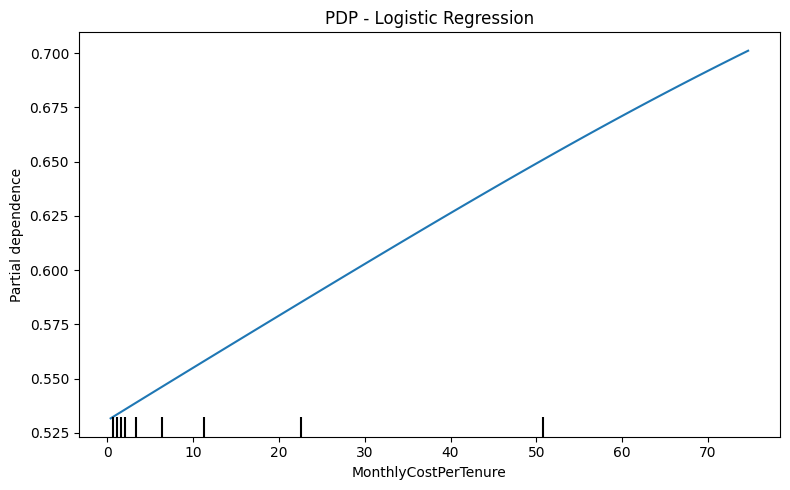

In [33]:
print("\nPDP - Logistic Regression")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(log_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - Logistic Regression")
plt.tight_layout()
plt.show()

This PDP visualizes the effect of the feature MonthlyCostPerTenure on the predicted probability of customer churn using a Logistic Regression model.

Interpretation:
The plot shows a positive and smooth upward trend, meaning that as MonthlyCostPerTenure increases, the model predicts a higher likelihood of churn.

Customers who pay more per month in a short subscription period are at greater risk of leaving the service.

### ICE for Logistic Regression


ICE - Logistic Regression


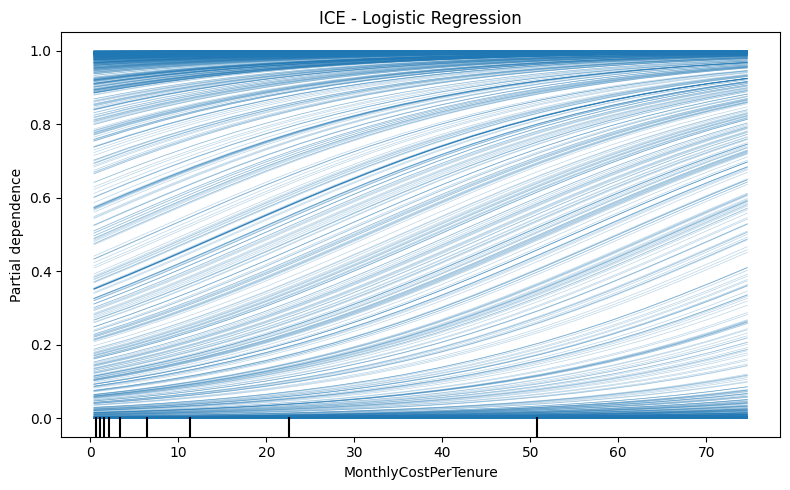

In [34]:
print("\nICE - Logistic Regression")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(log_final, X_test_final, features=[feature_index], kind="individual", grid_resolution=20, ax=ax)
ax.set_title("ICE - Logistic Regression")
plt.tight_layout()
plt.show()

This ICE plot shows how MonthlyCostPerTenure affects churn predictions in the Logistic Regression model for individual customers:

Most lines slope upward, meaning higher cost per tenure increases churn probability.

The model shows a smooth, linear trend, typical of Logistic Regression.

Many customers reach high churn risk as MonthlyCostPerTenure increases.

Confirms that paying more early in a contract is a strong churn signal.

## XGBoost Classifier Model

In [35]:
def clean_feature_names(df):
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
    return df

X_train_final = clean_feature_names(X_train_final)
X_test_final = clean_feature_names(X_test_final)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:43:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Evaluation
Accuracy: 0.94
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       544
           1       0.94      0.96      0.95       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



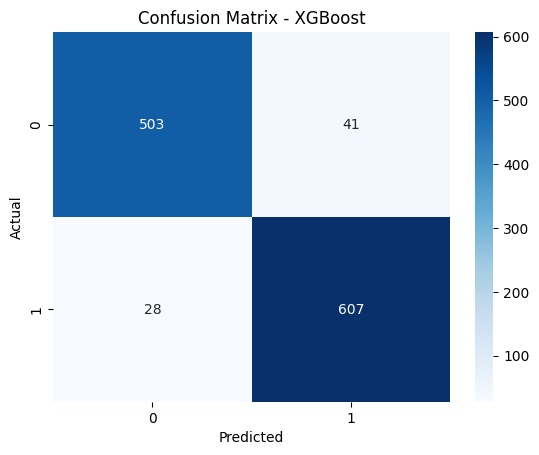

In [36]:
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_final.fit(X_train_final, y_train)
evaluate_model("XGBoost", xgb_final, X_test_final, y_test)

### SHAP for XGBoost


SHAP Summary for XGBoost


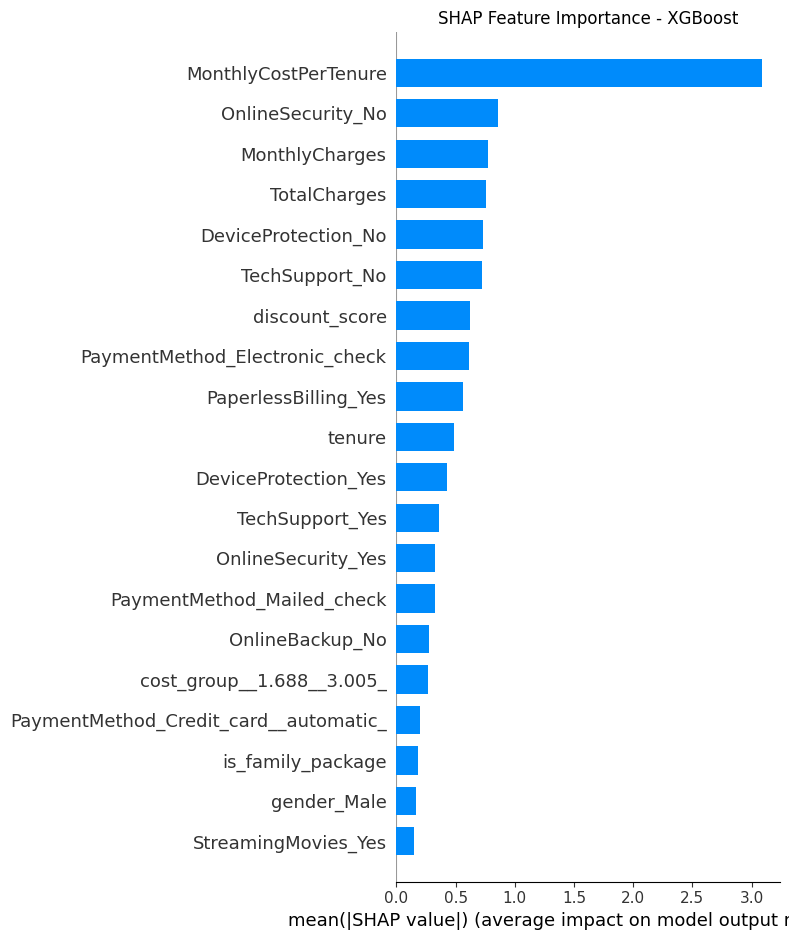

In [37]:
print("\nSHAP Summary for XGBoost")
explainer_xgb = shap.TreeExplainer(xgb_final)
shap_values_xgb = explainer_xgb.shap_values(X_test_final)
shap.summary_plot(shap_values_xgb, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

This SHAP bar plot highlights the most impactful features driving churn predictions:

* MonthlyCostPerTenure stands out as the most influential feature, indicating that customers who pay more per unit of tenure are at a higher risk of churn.

* Other strong contributors include:

    * OnlineSecurity_No and TechSupport_No, signaling that lack of support services increases churn risk.

    * Billing features like MonthlyCharges, TotalCharges, and PaymentMethod_Electronic check also play notable roles.

    * discount_score also shows moderate influence, suggesting that price sensitivity is important.

    * Features like tenure have lower importance here compared to Logistic Regression, likely because MonthlyCostPerTenure already captures tenure indirectly.

The XGBoost model focuses heavily on cost-related features and absence of value-added services to predict churn. This aligns with patterns seen across other models but emphasizes the compounded effect of cost efficiency (e.g., value for money) on customer retention.

### LIME for XGBoost

In [38]:
print("\nLIME Explanation for XGBoost")
exp = explainer.explain_instance(sample_instance.values, xgb_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for XGBoost


This LIME explanation provides a local interpretation of a single churn prediction:

* The model predicts 84% probability of churn for this customer.

* The top positive contributors (increasing churn likelihood) include:

    * High MonthlyCostPerTenure (43.80) — strong impact (+0.41)

    * No Online Security and No Device Protection — both increase churn risk due to absence of protective services

    * No Tech Support and Electronic Check payment method — also contribute positively toward churn.

* On the other hand, features that reduce churn probability include:

  * Having TechSupport_Yes, PaperlessBilling_Yes, and Credit card (automatic) payment — often associated with satisfied or long-term customers.

This LIME output confirms the global SHAP insight: cost-effectiveness and service availability are key churn drivers. This customer pays a lot early (high MonthlyCostPerTenure) and lacks security/support services, which the model strongly associates with higher churn risk.


### PDP for XGBoost


PDP - XGBoost


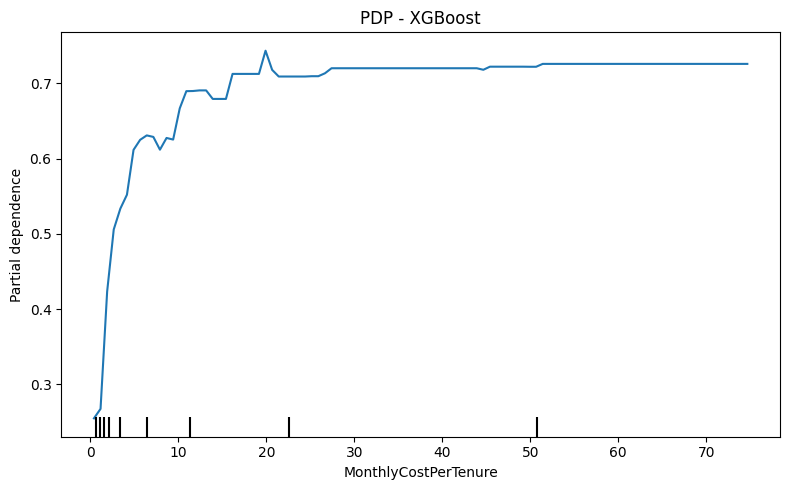

In [39]:
print("\nPDP - XGBoost")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(xgb_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - XGBoost")
plt.tight_layout()
plt.show()

This Partial Dependence Plot shows how the feature MonthlyCostPerTenure impacts churn predictions:

* The PDP indicates that as MonthlyCostPerTenure increases, the probability of churn increases sharply at first and then plateaus around a high value (~0.72).

* This suggests that customers who pay a high monthly charge relative to their tenure are much more likely to churn.

* After a certain threshold (~20 units), the model predicts consistently high churn risk, meaning that the risk stabilizes for extremely high values.

MonthlyCostPerTenure is a strong churn predictor in the XGBoost model. Customers paying disproportionately more than others early in their subscription are highly likely to churn.

### ICE for XGBoost

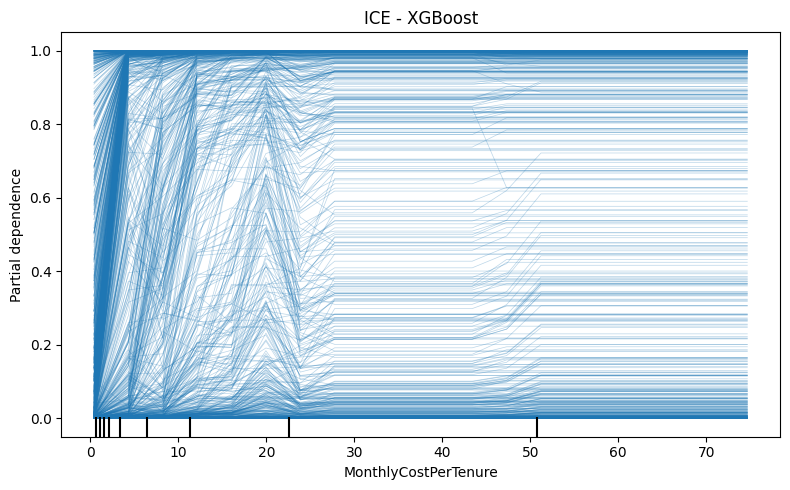

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(xgb_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - XGBoost")
plt.tight_layout()
plt.show()

This ICE plot shows the individual effects of the MonthlyCostPerTenure feature on predicted churn probability:

* Each blue line represents how churn probability changes for a specific customer as their MonthlyCostPerTenure varies.

* The majority of lines slope upward quickly and then flatten, indicating that higher costs relative to tenure sharply increase churn risk, especially in the lower ranges.

* After ~20 units, most lines reach high churn probability (close to 1.0), confirming a strong and consistent influence.

MonthlyCostPerTenure has a strong and consistent positive effect on churn predictions across most customers in the XGBoost model. This reinforces the feature’s critical role in model behavior and decision-making.